In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from tensorflow.keras.optimizers import Adam

## global variables

In [34]:
time_step = 24
# model specification
neurons = 250
epochs = 10
batch_size = 512

## helper functions

In [35]:
evaluation_results = []
# Modified evaluate_model function to store results in evaluation_results
def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

# Step 4: Prepare data for BiLSTM
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

def build_bilstm_model(time_step):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(time_step, 2))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1)) # output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_learning_curve(history, model_name):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title(f'Learning curve: {model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def data_prep():
    data = pd.read_csv('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/solar_weather copy 2.csv', header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])
    
    data = data[data.index.year == 2021]

    # data = data[(data.index.year == 2021)]

    dataset = data[['Energy delta[Wh]', 'GHI']]
    return dataset

In [36]:
dataset = data_prep()

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_40094/2124450807.py:55: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/solar_weather copy 2.csv', header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


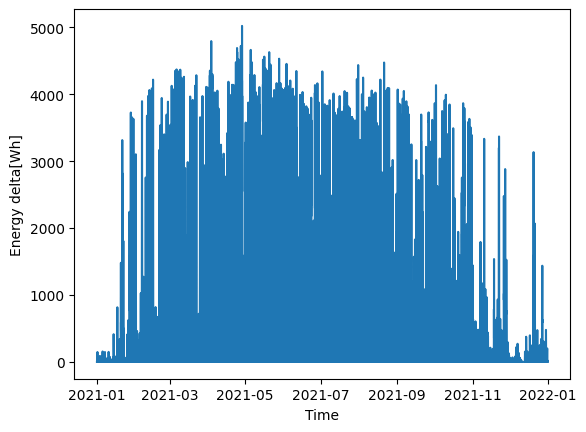

In [37]:
data_2021 = dataset.loc['2021']
plt.plot(data_2021.index, data_2021["Energy delta[Wh]"])
plt.xlabel("Time")
plt.ylabel("Energy delta[Wh]")
plt.show()

In [38]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(dataset)

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_40094/2552125360.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  scaled_data_df = pd.DataFrame(scaled_data, columns=['GHI', 'Energy delta[Wh]'], index=pd.date_range('2021-01-01', periods=len(scaled_data), freq='15T'))


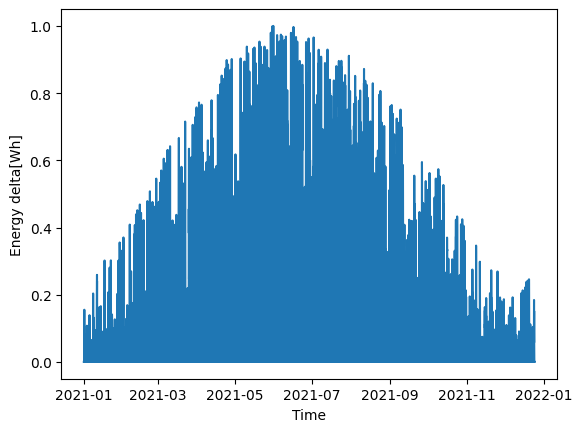

In [39]:
scaled_data_df = pd.DataFrame(scaled_data, columns=['GHI', 'Energy delta[Wh]'], index=pd.date_range('2021-01-01', periods=len(scaled_data), freq='15T'))

# Now you can use .loc to filter data for 2021
data_2021 = scaled_data_df.loc['2021']
plt.plot(data_2021.index, data_2021["Energy delta[Wh]"])
plt.xlabel("Time")
plt.ylabel("Energy delta[Wh]")
plt.show()

## Base BiLSTM

In [40]:



# Function to create sequences with time steps
# def create_dataset(dataset, time_step=1):
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

X, y = create_dataset(scaled_data, time_step)
print(f'X, y shape {X.shape} {y.shape}')
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dataset shape (34368, 2)
X, y shape (34344, 24, 2) (34344,)


In [41]:
print("Training BiLSTM only...")
print("\n")

model = build_bilstm_model(time_step)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

y_train_predict = scaler.inverse_transform(
    np.concatenate([y_train_predict, X_train[:, -1, 1:]], axis=1)
)[:, 0]

y_test_predict = scaler.inverse_transform(
    np.concatenate([y_test_predict, X_test[:, -1, 1:]], axis=1)
)[:, 0]

y_train_actual = scaler.inverse_transform(
    np.concatenate([y_train.reshape(-1, 1), X_train[:, -1, 1:]], axis=1)
)[:, 0]

y_test_actual = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1)
)[:, 0]

evaluate_model(y_train_actual, y_train_predict, 'BiLSTM', 'Training')
evaluate_model(y_test_actual, y_test_predict, 'BiLSTM', 'Testing')

Training BiLSTM only...


Epoch 1/10
54/54 [==============================] - 108s 2s/step - loss: 0.0106 - val_loss: 0.0014
Epoch 2/10
54/54 [==============================] - 94s 2s/step - loss: 0.0048 - val_loss: 0.0012
Epoch 3/10
54/54 [==============================] - 94s 2s/step - loss: 0.0043 - val_loss: 0.0011
Epoch 4/10
54/54 [==============================] - 106s 2s/step - loss: 0.0041 - val_loss: 9.8940e-04
Epoch 5/10
54/54 [==============================] - 99s 2s/step - loss: 0.0040 - val_loss: 9.2082e-04
Epoch 6/10
54/54 [==============================] - 126s 2s/step - loss: 0.0039 - val_loss: 9.3698e-04
Epoch 7/10
54/54 [==============================] - 122s 2s/step - loss: 0.0038 - val_loss: 8.5889e-04
Epoch 8/10
54/54 [==============================] - 150s 3s/step - loss: 0.0039 - val_loss: 8.4935e-04
Epoch 9/10
54/54 [==============================] - 185s 3s/step - loss: 0.0038 - val_loss: 8.0133e-04
Epoch 10/10
515/859 [================>.............] - ETA: 10

KeyboardInterrupt: 

In [ ]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Training,129.148327,86995.240378,294.949556,0.920663
1,BiLSTM,Testing,48.572053,20643.758471,143.679360,0.917622


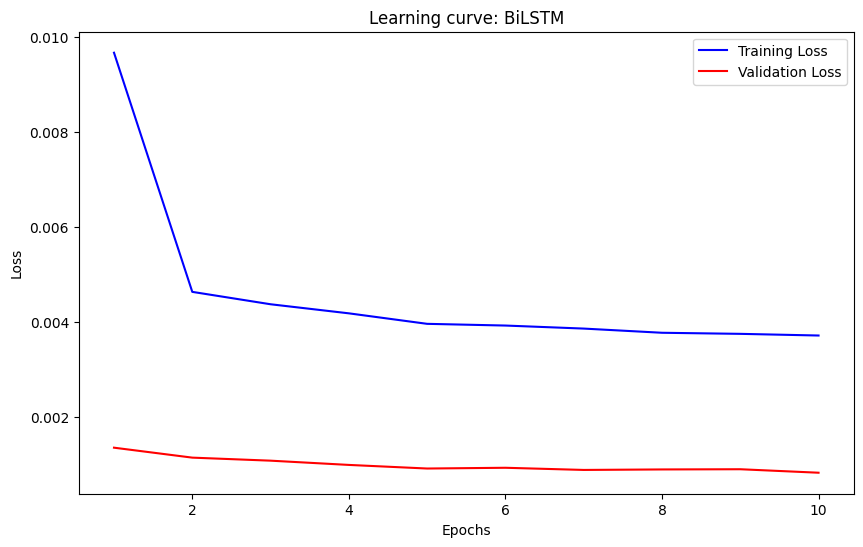

In [ ]:
plot_learning_curve(history, 'BiLSTM')

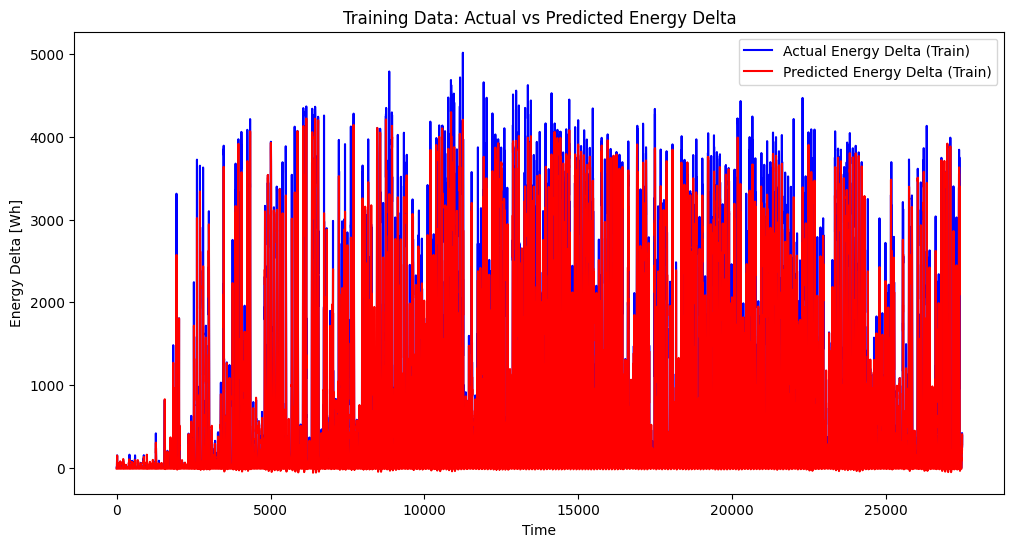

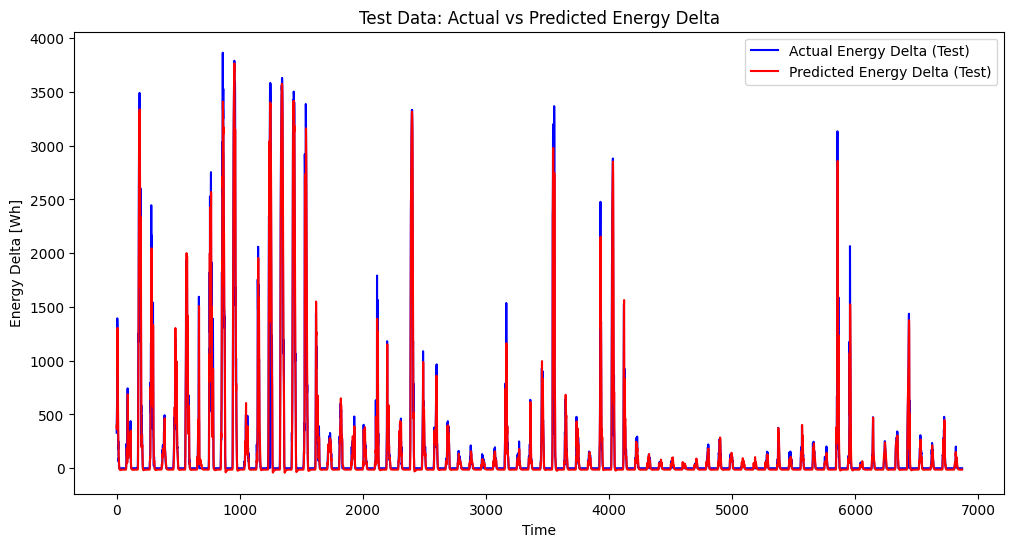

In [ ]:
import matplotlib.pyplot as plt

data_2021 = dataset.loc['2021']

# Plotting actual vs predicted for training data
plt.figure(figsize=(12, 6))
plt.plot( y_train_actual, label="Actual Energy Delta (Train)", color="blue")
plt.plot( y_train_predict, label="Predicted Energy Delta (Train)", color="red")
plt.title("Training Data: Actual vs Predicted Energy Delta")
plt.xlabel("Time")
plt.ylabel("Energy Delta [Wh]")
plt.legend()
plt.show()

# Plotting actual vs predicted for testing data
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Energy Delta (Test)", color="blue")
plt.plot(y_test_predict, label="Predicted Energy Delta (Test)", color="red")
plt.title("Test Data: Actual vs Predicted Energy Delta")
plt.xlabel("Time")
plt.ylabel("Energy Delta [Wh]")
plt.legend()
plt.show()

## GBDT-BiLSTM

In [ ]:
# Load and split data
# data = pd.read_csv('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/solar_weather copy 2.csv', header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])
# data = data[data.index.year == 2021]

# # dataset = data[['Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity']]
# dataset = data[['Energy delta[Wh]', 'GHI']]

dataset = data_prep()

X = dataset.iloc[:, 1:].values  # Features
y = dataset.iloc[:, 0].values   # Target

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_21811/2124450807.py:55: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/solar_weather copy 2.csv', header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


In [ ]:
# Step 1: Train GBDT, XGB, and CatBoost on the training data
gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

gbdt.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
gbdt_output_train = gbdt.predict(X_train)
gbdt_output_test = gbdt.predict(X_test)

In [ ]:
# Evaluate model performance on training and test sets
evaluate_model(y_train, gbdt_output_train, 'GBDT', 'Training')
evaluate_model(y_test, gbdt_output_test, 'GBDT', 'Testing')

In [ ]:
# scaler = StandardScaler()

# Step 3: Scale the model outputs
scaler = MinMaxScaler()
gbdt_output_train_scaled = scaler.fit_transform(gbdt_output_train.reshape(-1, 1))
gbdt_output_test_scaled = scaler.transform(gbdt_output_test.reshape(-1, 1))



# Create BiLSTM input for all three model outputs
X_train_bilstm_gbdt, y_train_bilstm_gbdt = create_dataset(gbdt_output_train_scaled, time_step)
X_test_bilstm_gbdt, y_test_bilstm_gbdt = create_dataset(gbdt_output_test_scaled, time_step)

# Reshape X to be (samples, time_steps, features)
X_train_bilstm_gbdt = X_train_bilstm_gbdt.reshape(X_train_bilstm_gbdt.shape[0], time_step, 1)
X_test_bilstm_gbdt = X_test_bilstm_gbdt.reshape(X_test_bilstm_gbdt.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on GBDT outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_gbdt = model.fit(X_train_bilstm_gbdt, y_train_bilstm_gbdt, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_gbdt, y_test_bilstm_gbdt), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_gbdt_scaled = model.predict(X_test_bilstm_gbdt)

y_pred_bilstm_gbdt = scaler.inverse_transform(y_pred_bilstm_gbdt_scaled)
y_test_bilstm_gbdt_actual_rescaled = scaler.inverse_transform(y_test_bilstm_gbdt.reshape(-1, 1))

evaluate_model(y_test_bilstm_gbdt_actual_rescaled, y_pred_bilstm_gbdt, 'BiLSTM (GBDT)', 'Testing')

dataset shape (27494, 1)
dataset shape (6874, 1)
Training BiLSTM on GBDT outputs...


Epoch 1/10
54/54 [==============================] - 31s 542ms/step - loss: 0.0134 - val_loss: 5.0190e-04
Epoch 2/10
54/54 [==============================] - 30s 564ms/step - loss: 0.0037 - val_loss: 6.6943e-04
Epoch 3/10
54/54 [==============================] - 28s 524ms/step - loss: 0.0031 - val_loss: 3.6201e-04
Epoch 4/10
54/54 [==============================] - 28s 524ms/step - loss: 0.0028 - val_loss: 4.1741e-04
Epoch 5/10
54/54 [==============================] - 27s 504ms/step - loss: 0.0027 - val_loss: 2.9374e-04
Epoch 6/10
54/54 [==============================] - 29s 546ms/step - loss: 0.0026 - val_loss: 3.2222e-04
Epoch 7/10
54/54 [==============================] - 27s 505ms/step - loss: 0.0023 - val_loss: 3.3961e-04
Epoch 8/10
54/54 [==============================] - 27s 506ms/step - loss: 0.0024 - val_loss: 2.6345e-04
Epoch 9/10
54/54 [==============================] - 30s 552ms/step - loss:

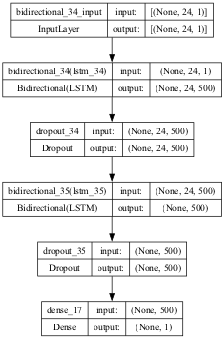

In [ ]:
# Plotting the model architecture

plot_model(model, to_file='bilstm_gbdt.png', show_shapes=True, show_layer_names=True, dpi=50)


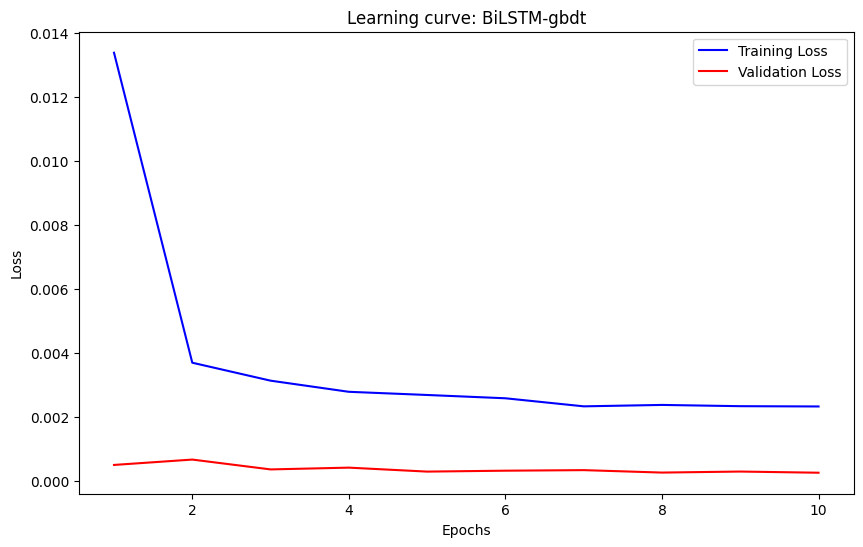

In [ ]:
plot_learning_curve(history_gbdt, 'BiLSTM-gbdt')

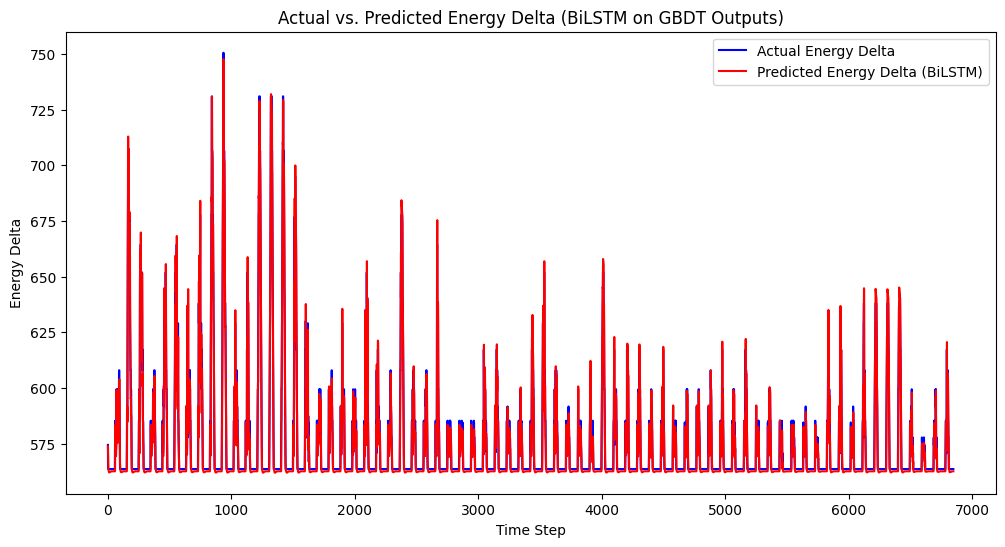

In [ ]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_gbdt_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_gbdt, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on GBDT Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [ ]:

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data

xgb = XGBRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

xgb.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
xgb_output_train = xgb.predict(X_train)
xgb_output_test = xgb.predict(X_test)

evaluate_model(y_train, xgb_output_train, 'XGB', 'Training')
evaluate_model(y_test, xgb_output_test, 'XGB', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()

xgb_output_train_scaled = scaler.fit_transform(xgb_output_train.reshape(-1, 1))
xgb_output_test_scaled = scaler.transform(xgb_output_test.reshape(-1, 1))


# Create BiLSTM input for all three model outputs

X_train_bilstm_xgb, y_train_bilstm_xgb = create_dataset(xgb_output_train_scaled, time_step)
X_test_bilstm_xgb, y_test_bilstm_xgb = create_dataset(xgb_output_test_scaled, time_step)

X_train_bilstm_xgb = X_train_bilstm_xgb.reshape(X_train_bilstm_xgb.shape[0], time_step, 1)
X_test_bilstm_xgb = X_test_bilstm_xgb.reshape(X_test_bilstm_xgb.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs

print("Training BiLSTM on XGB outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_xgb = model.fit(X_train_bilstm_xgb, y_train_bilstm_xgb, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_xgb, y_test_bilstm_xgb), verbose=1)

# Step 7: Predict with BiLSTM

y_pred_bilstm_xgb_scaled = model.predict(X_test_bilstm_xgb)
y_pred_bilstm_xgb = scaler.inverse_transform(y_pred_bilstm_xgb_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_xgb_actual_rescaled = scaler.inverse_transform(y_test_bilstm_xgb.reshape(-1, 1))

evaluate_model(y_test_bilstm_xgb_actual_rescaled, y_pred_bilstm_xgb, 'BiLSTM (XGB)', 'Testing')

dataset shape (27494, 1)
dataset shape (6874, 1)
Training BiLSTM on XGB outputs...


Epoch 1/10
54/54 [==============================] - 32s 565ms/step - loss: 0.0184 - val_loss: 7.5749e-04
Epoch 2/10
54/54 [==============================] - 30s 560ms/step - loss: 0.0046 - val_loss: 5.4717e-04
Epoch 3/10
25/54 [============>.................] - ETA: 13s - loss: 0.0041

KeyboardInterrupt: 

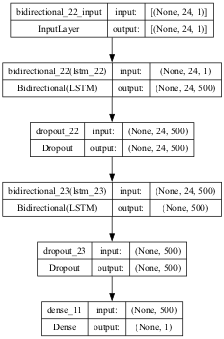

In [ ]:
# Plotting the model architecture
plot_model(model, to_file='bilstm_xgb.png', show_shapes=True, show_layer_names=True, dpi=50)

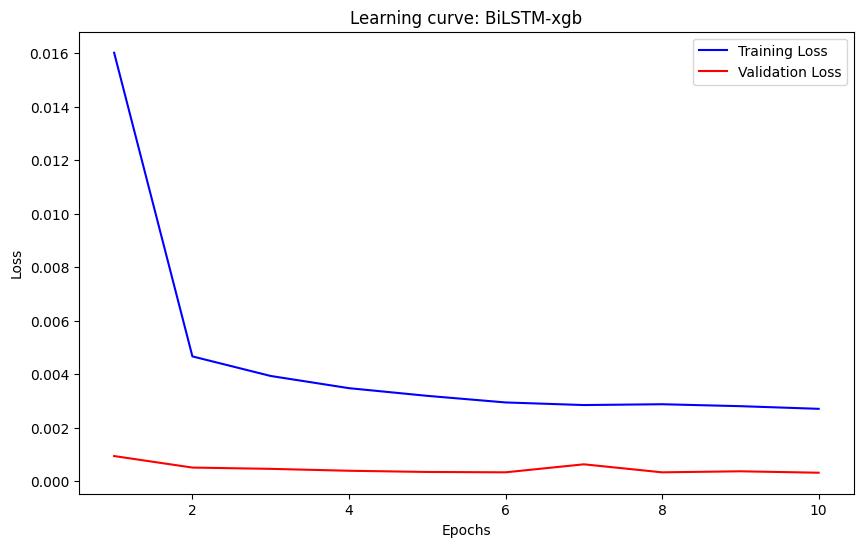

In [ ]:
plot_learning_curve(history_xgb, 'BiLSTM-xgb')

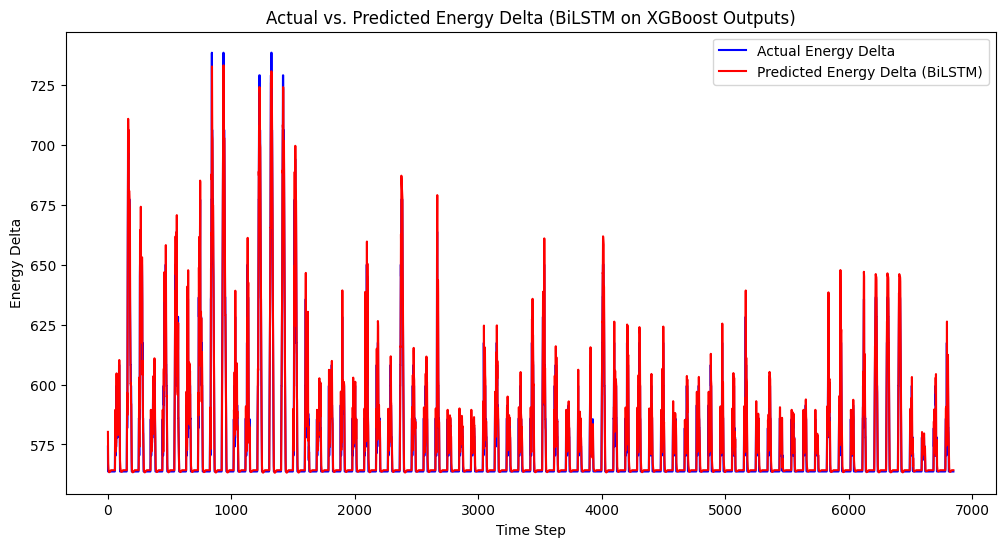

In [ ]:
import matplotlib.pyplot as plt



# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_xgb_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_xgb, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on XGBoost Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [ ]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data
catboost = CatBoostRegressor(n_estimators=100, learning_rate=0.001, depth=5)

catboost.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
catboost_output_train = catboost.predict(X_train)
catboost_output_test = catboost.predict(X_test)

# Evaluate model performance on training and test sets 
evaluate_model(y_train, catboost_output_train, 'Catboost', 'Training')
evaluate_model(y_test, catboost_output_test, 'Catboost', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()

catboost_output_train_scaled = scaler.fit_transform(catboost_output_train.reshape(-1, 1))
catboost_output_test_scaled = scaler.transform(catboost_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_catboost, y_train_bilstm_catboost = create_dataset(catboost_output_train_scaled, time_step)
X_test_bilstm_catboost, y_test_bilstm_catboost = create_dataset(catboost_output_test_scaled, time_step)

X_train_bilstm_catboost = X_train_bilstm_catboost.reshape(X_train_bilstm_catboost.shape[0], time_step, 1)
X_test_bilstm_catboost = X_test_bilstm_catboost.reshape(X_test_bilstm_catboost.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on CatBoost outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_catboost = model.fit(X_train_bilstm_catboost, y_train_bilstm_catboost, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_catboost, y_test_bilstm_catboost), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_catboost_scaled = model.predict(X_test_bilstm_catboost)
y_pred_bilstm_catboost = scaler.inverse_transform(y_pred_bilstm_catboost_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_catboost_actual_rescaled = scaler.inverse_transform(y_test_bilstm_catboost.reshape(-1, 1))

evaluate_model(y_test_bilstm_catboost_actual_rescaled, y_pred_bilstm_catboost, 'BiLSTM (CatBoost)', 'Testing')

0:	learn: 1046.0880600	total: 5.33ms	remaining: 528ms
1:	learn: 1045.2329990	total: 6.96ms	remaining: 341ms
2:	learn: 1044.3808254	total: 8.51ms	remaining: 275ms
3:	learn: 1043.5335305	total: 10ms	remaining: 241ms
4:	learn: 1042.6857025	total: 13ms	remaining: 247ms
5:	learn: 1041.8368113	total: 14.6ms	remaining: 229ms
6:	learn: 1040.9831891	total: 16.3ms	remaining: 216ms
7:	learn: 1040.1387749	total: 18.2ms	remaining: 210ms
8:	learn: 1039.2884723	total: 19.4ms	remaining: 196ms
9:	learn: 1038.4350443	total: 20.5ms	remaining: 185ms
10:	learn: 1037.5925138	total: 21.7ms	remaining: 175ms
11:	learn: 1036.7465343	total: 22.9ms	remaining: 168ms
12:	learn: 1035.9014144	total: 24ms	remaining: 160ms
13:	learn: 1035.0562282	total: 25.1ms	remaining: 154ms
14:	learn: 1034.2211668	total: 26.2ms	remaining: 149ms
15:	learn: 1033.3772687	total: 27.2ms	remaining: 143ms
16:	learn: 1032.5398549	total: 28.3ms	remaining: 138ms
17:	learn: 1031.7037175	total: 29.5ms	remaining: 134ms
18:	learn: 1030.8652965	to

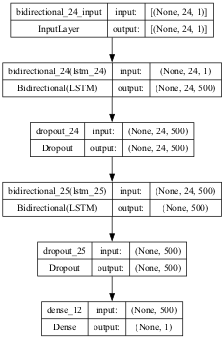

In [ ]:
plot_model(model, to_file='bilstm_catboost.png', show_shapes=True, show_layer_names=True, dpi=50)


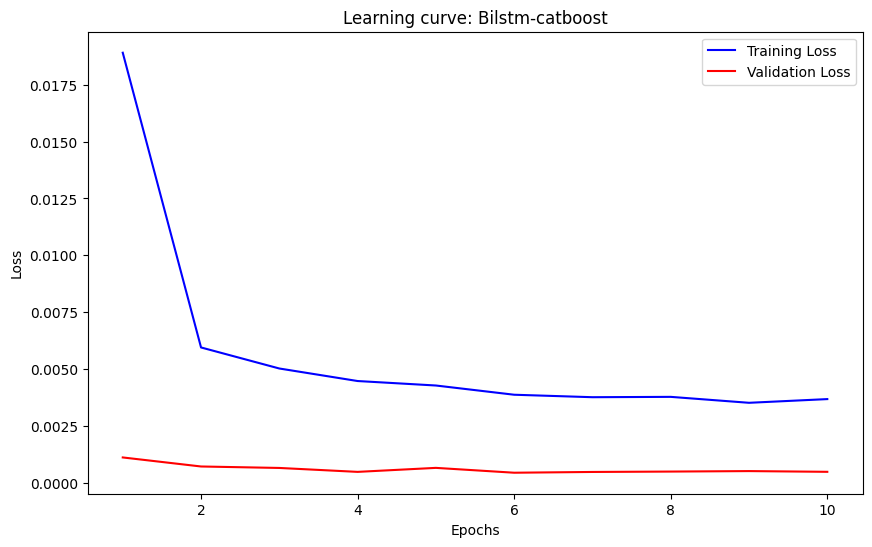

In [ ]:
plot_learning_curve(history_catboost, 'Bilstm-catboost')

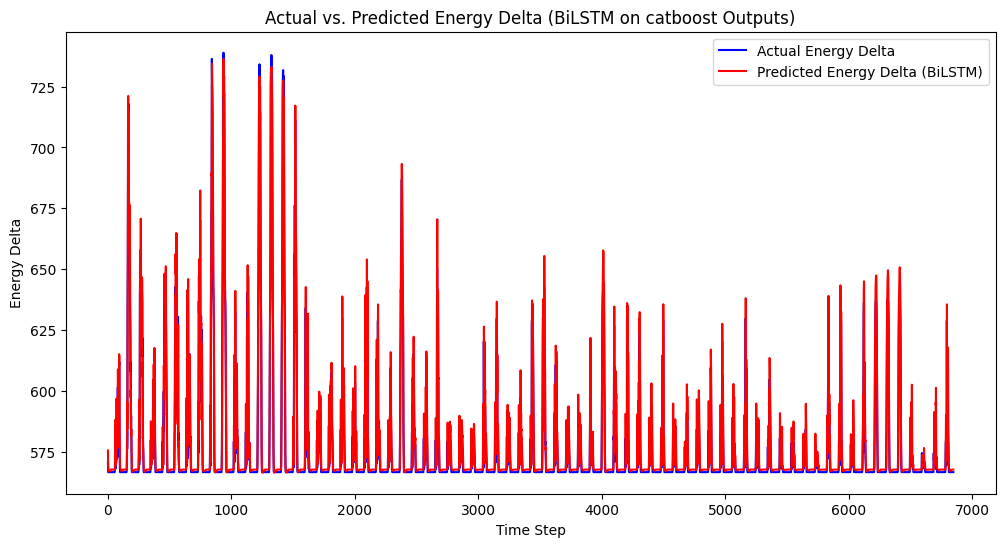

In [ ]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_catboost_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_catboost, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on catboost Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [ ]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

lgbm.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
lgbm_output_train = lgbm.predict(X_train)
lgbm_output_test = lgbm.predict(X_test)


# Evaluate model performance on training and test sets
evaluate_model(y_train, lgbm_output_train, 'LightGBM', 'Training')
evaluate_model(y_test, lgbm_output_test, 'LightGBM', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()
lgbm_output_train_scaled = scaler.fit_transform(lgbm_output_train.reshape(-1, 1))
lgbm_output_test_scaled = scaler.transform(lgbm_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_lgbm, y_train_bilstm_lgbm = create_dataset(lgbm_output_train_scaled, time_step)
X_test_bilstm_lgbm, y_test_bilstm_lgbm = create_dataset(lgbm_output_test_scaled, time_step)

# Reshape X to be (samples, time_steps, features)
X_train_bilstm_lgbm = X_train_bilstm_lgbm.reshape(X_train_bilstm_lgbm.shape[0], time_step, 1)
X_test_bilstm_lgbm = X_test_bilstm_lgbm.reshape(X_test_bilstm_lgbm.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on GBDT outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_lgbm = model.fit(X_train_bilstm_lgbm, y_train_bilstm_lgbm, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_lgbm, y_test_bilstm_lgbm), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_lgbm_scaled = model.predict(X_test_bilstm_lgbm)
y_pred_bilstm_lgbm = scaler.inverse_transform(y_pred_bilstm_lgbm_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_lgbm_actual_rescaled = scaler.inverse_transform(y_test_bilstm_lgbm.reshape(-1, 1))
evaluate_model(y_test_bilstm_lgbm_actual_rescaled, y_pred_bilstm_lgbm, 'BiLSTM (LightGBM)', 'Testing')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 27494, number of used features: 1
[LightGBM] [Info] Start training from score 622.931512
dataset shape (27494, 1)
dataset shape (6874, 1)
Training BiLSTM on GBDT outputs...


Epoch 1/10
54/54 [==============================] - 31s 539ms/step - loss: 0.0146 - val_loss: 6.7645e-04
Epoch 2/10
54/54 [==============================] - 29s 546ms/step - loss: 0.0039 - val_loss: 4.0151e-04
Epoch 3/10
54/54 [==============================] - 30s 554ms/step - loss: 0.0033 - val_loss: 6.6505e-04
Epoch 4/10
54/54 [==============================] - 28s 525ms/step - loss: 0.0031 - val_loss: 3.8932e-04
Epoch 5/10
54/54 [==============================] - 31s 576ms/step - loss: 0.0027 - val_

KeyboardInterrupt: 

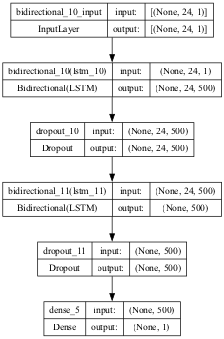

In [ ]:
plot_model(model, to_file='bilstm_lightgbm.png', show_shapes=True, show_layer_names=True, dpi=50)

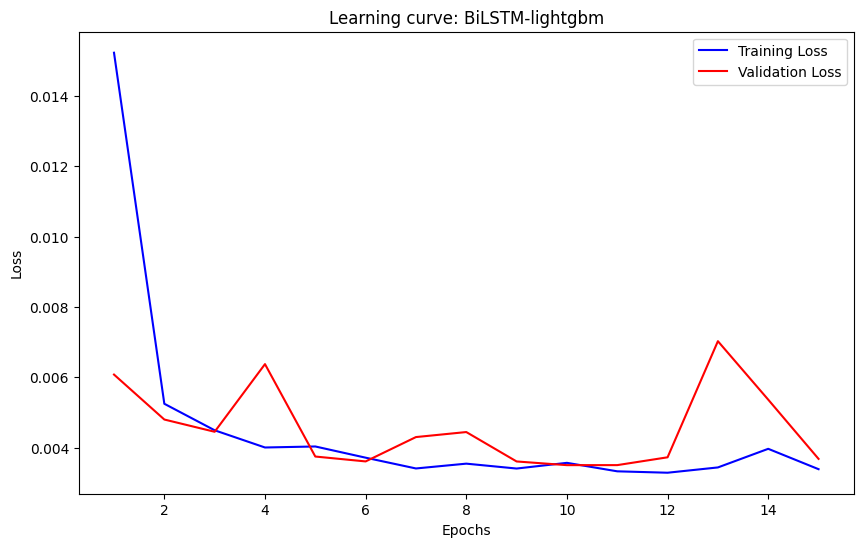

In [ ]:
plot_learning_curve(history_lgbm, 'BiLSTM-lightgbm')

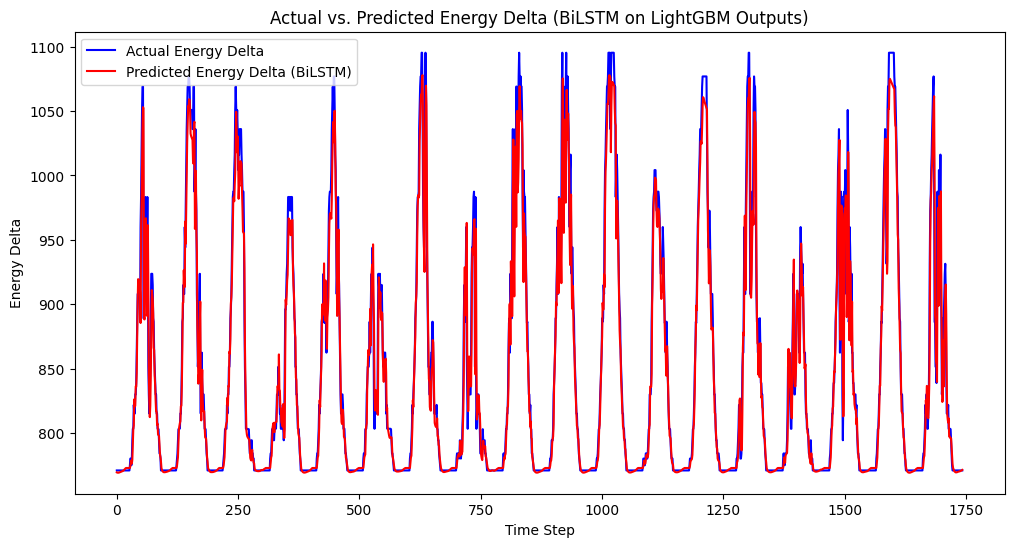

In [ ]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_lgbm_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_lgbm, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on LightGBM Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [ ]:
results_df = pd.DataFrame(evaluation_results)
print("\nevaluation metrics table: ")


evaluation metrics table: 


In [ ]:
results_df

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Training,160.450865,9.526313e+04,308.647264,0.927684
1,BiLSTM,Testing,177.562660,1.182518e+05,343.877585,0.862318
2,GBDT,Training,860.903518,1.146995e+06,1070.978569,0.162216
3,GBDT,Testing,835.618057,1.027896e+06,1013.851969,0.155361
4,BiLSTM (GBDT),Testing,11.109899,4.352535e+02,20.862729,0.952111
5,XGB,Training,861.173710,1.148214e+06,1071.547291,0.161326
6,XGB,Testing,835.704882,1.027833e+06,1013.820804,0.155413
7,BiLSTM (XGB),Testing,11.264401,4.424837e+02,21.035295,0.951334
8,Catboost,Training,863.072737,1.154643e+06,1074.543335,0.156629
9,Catboost,Testing,836.881124,1.030228e+06,1015.001317,0.153445


In [ ]:
from tensorflow.keras import backend as K
K.clear_session()